## Assignment notebook 10.7

Chloe Hacker

Your assignment is to apply a probabilistic model similar to the switchpoint model in notebook 10.6. You can either follow the instructions below to generate a model like in notebook 10.6, or if you are feeling ambitious, you can choose another example model implementation from the examples section of the pymc3 documentation.

You task is to use np.random to generate data under a known distribution and then to apply probabilistic inference using pymc3 to fit a model for the parameters of your generative model. 

In [35]:
# suppress warning messages from pymc3
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as ss
import toyplot
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-darkgrid'])

In [60]:
# fix a random seed
np.random.seed(7)

# generate data
data = pd.DataFrame({
    "dogs_owned": np.arange(0, 25),
    "how_good_dogs_are": np.concatenate([
        np.random.poisson(6.0, 15),
        np.random.poisson(1.0, 10),
    ])
})

# introduce some random NaN values (pymc3 will handle these)
missing = np.random.randint(0, data.shape[0], 5)
data.loc[missing, "how_good_dogs_are"] = np.nan

In [61]:
data.head()

,dogs_owned,how_good_dogs_are
0,0,7.0
1,1,5.0
2,2,5.0
3,3,8.0
4,4,7.0


In [62]:
toyplot.scatterplot(
    data.dogs_owned,
    data.how_good_dogs_are, 
    width=500, 
    height=350,
    size=8, 
    opacity=0.6,
    xlabel="dogs owned", 
    ylabel="how good the dogs are",
);

0 5 10 15 20 25 dogs owned 0 3 6 9 how good the dogs are

In [65]:
with pm.Model() as dogs_model:

    # sample switchpoint from within the bounds of our data timescale
    switchpoint = pm.DiscreteUniform(
        'switchpoint',
        lower=data.dogs_owned.min(), 
        upper=data.dogs_owned.max(), 
        testval=3)

    # Priors for pre- and post-switch rates for number of dogs
    early_rate = pm.Exponential('early_rate', 1.)
    late_rate = pm.Exponential('late_rate', 1.)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= data.dogs_owned, early_rate, late_rate)

    dogs = pm.Poisson('dogs', rate, observed=data.how_good_dogs_are)

In [66]:
with dogs_model:
    trace = pm.sample(5500)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [dogs_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate_log__, early_rate_log__]
 99%|█████████▉| 5960/6000 [00:05<00:00, 1094.49it/s]/Users/chloehacker/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 6000/6000 [00:05<00:00, 1091.35it/s]
/Users/chloehacker/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Tuning was enabled throughout the whole trace.
Tuning was enabled throughout the whole trace.
The estimated number of effective samples is smaller than 200 for some parameters.


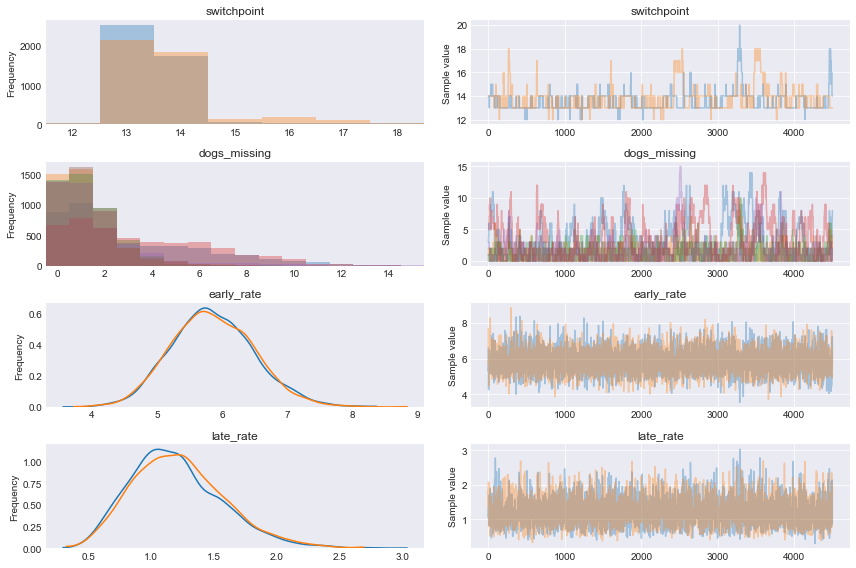

In [67]:
pm.traceplot(trace[1000:]);    #throws out first 1000 values

In [68]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
switchpoint,13.627545,0.864610,0.056266,12.000000,15.000000,110.0,1.006434
dogs_missing__0,3.431818,3.037985,0.211320,0.000000,9.000000,135.0,1.003679
dogs_missing__1,1.398727,1.631875,0.098383,0.000000,4.000000,179.0,1.008812
dogs_missing__2,1.250273,1.236270,0.047586,0.000000,4.000000,497.0,1.000119
early_rate,5.843057,0.631922,0.008390,4.658128,7.117822,4790.0,0.999922
late_rate,1.212917,0.366256,0.007505,0.541057,1.926455,2471.0,1.000302


Are your parameters within the 95% HPD interval? Do you think you ran the MCMC sampler long enough? Do you think anything went wrong? If so, what did you try to troubleshoot the problem? Did you seek help or answers?

The switchpoint was estimated at 13.6 which was close to the actualy of 14.5 and are within the HPD interval. I think the sampler ran for long enough, it ran for about a minute with no issues. 

